In [5]:
import os
from glob import glob
from tkinter import image_types

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split


In [58]:
DATA_PATH = "dataset"

#Wyszukiwanie wszystkich plików .jpg w podkatalogu
all_files = glob(os.path.join(DATA_PATH, "*", "*.jpg"))

def get_metadata(file_path):
    # Nazwa klasy to folder, w którym znajduje się plik
    class_name = os.path.basename(os.path.dirname(file_path))

    #Okreslenie typu obrazu na podstawie konwencji nazewnictwa w plikach
    file_name = os.path.basename(file_path).lower()
    if "stamp" in file_name:
        image_type = "Stamp"
    elif "scanned" in file_name:
        image_type = "Scanned"
    else:
        image_type = "Hand-Drawn"

    return class_name, image_type

#Tworzenie DataFrame
data = [get_metadata(i) + (i,) for i in all_files]
data_df = pd.DataFrame(data, columns=["class_name", "image_type", "filepath"])

print(f"Liczba znalezionych: {len(data_df)}")
print(f"Liczba unikalnych klas: {data_df['class_name'].unique()}")

if len(data_df) == 0:
    print("Sprawdz sciezke")
else:
    print("Przykladowe rekordy")
    print(data_df.head())





Liczba znalezionych: 431
Liczba unikalnych klas: ['anchor' 'balloon' 'bicycle' 'envelope' 'paper_boat' 'peace_symbol'
 'smiley' 'speech_bubble' 'spiral' 'thumb']
Przykladowe rekordy
  class_name  image_type                    filepath
0     anchor  Hand-Drawn  dataset\anchor\digit01.jpg
1     anchor  Hand-Drawn  dataset\anchor\digit02.jpg
2     anchor  Hand-Drawn  dataset\anchor\digit03.jpg
3     anchor  Hand-Drawn  dataset\anchor\digit04.jpg
4     anchor  Hand-Drawn  dataset\anchor\digit05.jpg


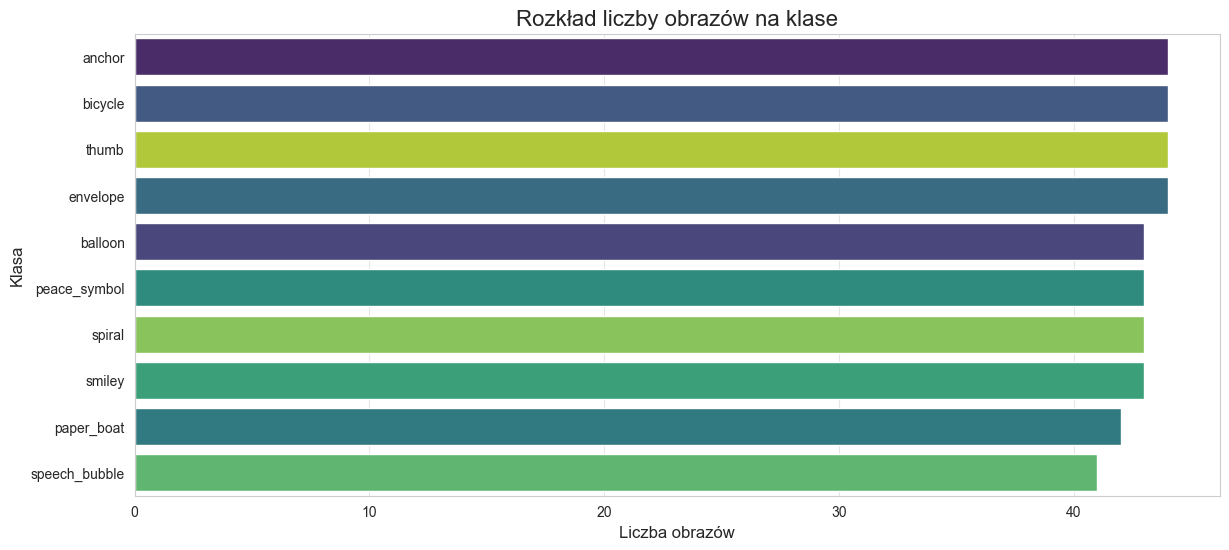

Najwieksza klasa ma: 44 próbek
Najmneijsza klasa ma: 41 próbek
Wniosek - Dataset jest dobrze zbalansowany pod względem ilości próbek na klasę


In [43]:
plt.figure(figsize=(14, 6))
sns.countplot(y="class_name", data=data_df, order=data_df["class_name"].value_counts().index, palette="viridis", hue="class_name", legend=False)
plt.title("Rozkład liczby obrazów na klase", fontsize=16)
plt.xlabel("Liczba obrazów", fontsize=12)
plt.ylabel("Klasa", fontsize=12)
plt.grid(axis="x", alpha=0.5)
plt.show()

#Wyrefikacja niezbalansowana
class_counts = data_df["class_name"].value_counts()
min_count = class_counts.min()
max_count = class_counts.max()

print(f"Najwieksza klasa ma: {max_count} próbek")
print(f"Najmneijsza klasa ma: {min_count} próbek")

#Wniosek 1: Analiza binalsu

if max_count / min_count > 1.2:
    print(f"Potencjalny problem -> Występuje niewielkie niezbalansowanie (stosunek: {max_count / min_count:.2f}). Może być wymagany ważony trening.")

else:
    print("Wniosek - Dataset jest dobrze zbalansowany pod względem ilości próbek na klasę")


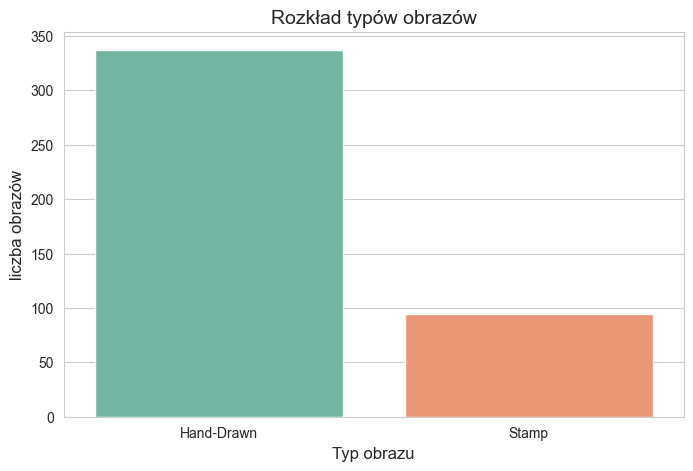

In [44]:
plt.figure(figsize=(8,5))
sns.countplot(x='image_type', data=data_df, palette="Set2", hue="image_type", legend=False)
plt.title("Rozkład typów obrazów", fontsize=14)
plt.xlabel("Typ obrazu", fontsize=12)
plt.ylabel("liczba obrazów", fontsize=12)
plt.show()

In [52]:
# Analiza 100 losowych próbek pod kątem rozmiaru i trybu koloru
sample_files = data_df["filepath"].sample(min(200, len(data_df)), random_state=42)
sizes = []
modes = []

for f in sample_files:
    try:
        img = Image.open(f)
        sizes.append(img.size)
        modes.append(img.mode)
    except Exception as e:
        print(f"Błąd wczytywania pliku {f}: {e}")

widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]

print("\nStatystyki Rozmiarów Obrazów:")
print(f"Unikalne rozmiary: {set(sizes) if len(set(sizes)) < 10 else 'Wiele różnych rozmiarów'}")
print(f"Mediana szerokośći: {np.median(widths)}, mediana wysokośći: {np.median(heights)}")

mode_counts = pd.Series(modes).value_counts()
print("\nStatystyki Głębi kolorów (Tryb PIL):")
print(mode_counts)

if len(set(sizes)) > 1:
    print("\nWNIOSEK EDA: Rozmiary obrazów są niejednorodne. Wymagana unifikacja (`Resize`) w Etapie 2.")
else:
    print("\nOK")
if len(mode_counts) > 1:
    print("WNIOSEK EDA: Występują mieszane tryby kolorów (np. RGB i Grayscale). Wymagana konwersja na jednolity format (np. RGB) w Etapie 2.")
else:
    print("\nOK")




Statystyki Rozmiarów Obrazów:
Unikalne rozmiary: {(160, 130)}
Mediana szerokośći: 160.0, mediana wysokośći: 130.0

Statystyki Głębi kolorów (Tryb PIL):
L    200
Name: count, dtype: int64

OK

OK


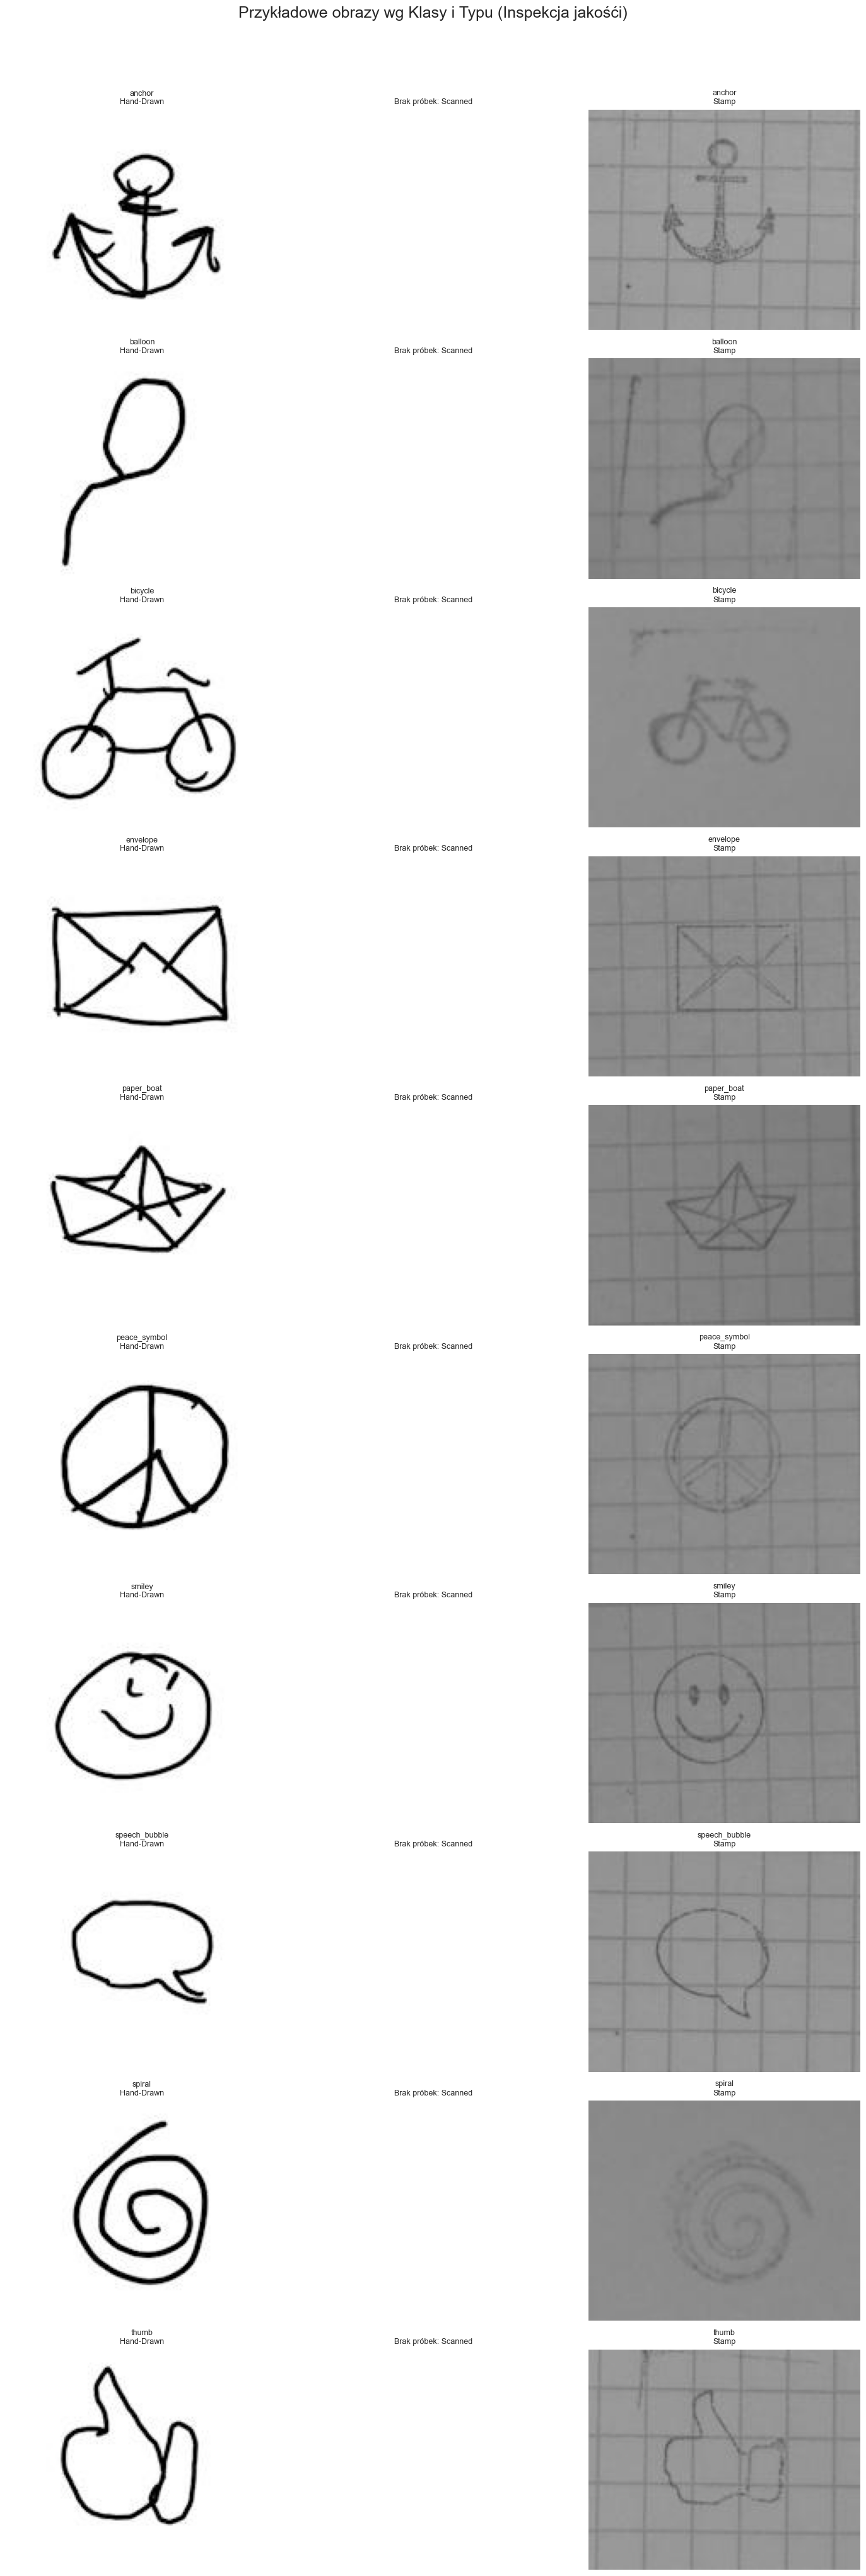


**KLUCZOWE WYNIKI WIZUALNE:** Wysoka zmienność tła i szumu. Wymagana będzie solidna normalizacja i augmentacja, aby model nauczył się cech rysunku, a nie tła.


In [56]:
#Wizualizacja próbek
classes = data_df["class_name"].unique()
fig, axes = plt.subplots(len(classes), 3, figsize=(14, 4 * len(classes)))
plt.suptitle("Przykładowe obrazy wg Klasy i Typu (Inspekcja jakośći)", y=1.02, fontsize=18)

for i, class_name in enumerate(classes):
    class_data = data_df[data_df["class_name"] == class_name]

    for j, img_type in enumerate(["Hand-Drawn", "Scanned", "Stamp"]):
        sample = class_data[class_data["image_type"] == img_type].head(1)

        if not sample.empty:
            filepath = sample["filepath"].iloc[0]
            img = Image.open(filepath).convert("RGB")
            axes[i,j].imshow(img)
            axes[i,j].set_title(f"{class_name}\n{img_type}", fontsize=9)
        else:
            axes[i,j].set_title(f"Brak próbek: {img_type}", fontsize=9)

        axes[i,j].axis("off")

plt.tight_layout()
plt.show()

print("\n**KLUCZOWE WYNIKI WIZUALNE:** Wysoka zmienność tła i szumu. Wymagana będzie solidna normalizacja i augmentacja, aby model nauczył się cech rysunku, a nie tła.")